In [2]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge
import warnings
# warnings.filterwarnings('ignore')

In [3]:
print(os.getcwd())

C:\Users\srish\0.4Learning


In [6]:
train = pd.read_csv('D:\\EverythingDS\\DataSets\\Mercari\\train.tsv', sep = '\t')

### EDA

##### Summary of data

In [7]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
train.shape

(1482535, 8)

In [9]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [10]:
train.describe().round(2)

,train_id,item_condition_id,price,shipping
count,1482535.00,1482535.00,1482535.00,1482535.00
mean,741267.00,1.91,26.74,0.45
std,427971.14,0.90,38.59,0.50
min,0.00,1.00,0.00,0.00
25%,370633.50,1.00,10.00,0.00
50%,741267.00,2.00,17.00,0.00
75%,1111900.50,3.00,29.00,1.00
max,1482534.00,5.00,2009.00,1.00


In [11]:
train.astype('object').describe().transpose()

,count,unique,top,freq
train_id,1482535,1482535,1482534,1
name,1482535,1225273,Bundle,2232
item_condition_id,1482535,5,1,640549
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
price,1.48254e+06,828,10,99416
shipping,1482535,2,0,819435
item_description,1482531,1281426,No description yet,82489


In [12]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [13]:
def fill_missing_value(data):
    data['category_name'].fillna(value = 'Other', inplace=True)
    data['brand_name'].fillna(value = 'uknown', inplace=True)
    data['item_description'].fillna(value = 'No description yet', inplace=True)
    return data

In [14]:
train = fill_missing_value(train)
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

##### Examining - Price (Target Variable)

In [15]:
train.price.describe().round(2)

count    1482535.00
mean          26.74
std           38.59
min            0.00
25%           10.00
50%           17.00
75%           29.00
max         2009.00
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

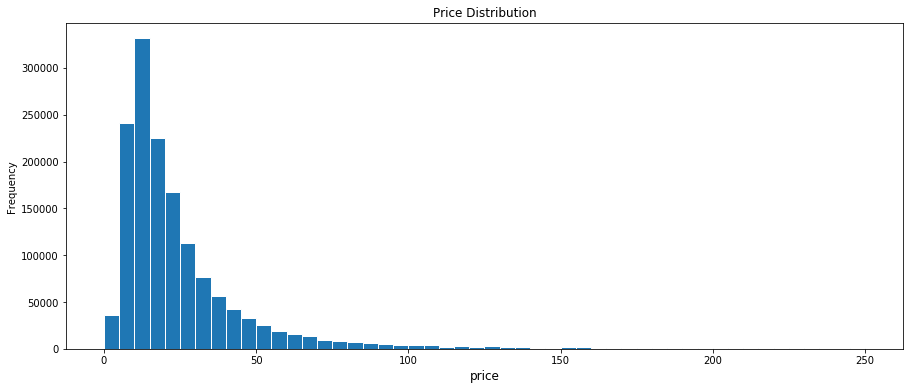

In [16]:
(train['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

Text(0.5, 1.0, 'Log Price Distribution')

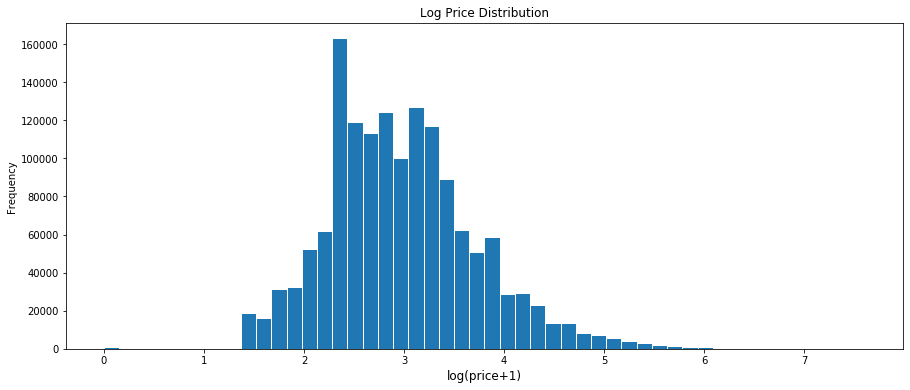

In [17]:
np.log(train['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

In [18]:
(train['price'] == 0).value_counts()

False    1481661
True         874
Name: price, dtype: int64

In [19]:
train[train.price==0]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,uknown,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,uknown,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,uknown,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,uknown,0.0,1,5 pair gap jean excellent used condition 3 chi...
...,...,...,...,...,...,...,...,...
1474172,1474172,Homecoming or Dama ivory dress,2,"Women/Dresses/Above Knee, Mini",uknown,0.0,0,Ivory formal dress. I wore this dress once for...
1474198,1474198,Tie up flannel top,3,Women/Tops & Blouses/Blouse,uknown,0.0,1,I got this last year and just didnt wear it mu...
1477958,1477958,Rae Dunn Measuring Pear,3,Home/Home Décor/Home Décor Accents,uknown,0.0,0,The dash lid appears it was dropped and a piec...
1478519,1478519,4 pairs women's wool boots socks,1,Women/Shoes/Boots,uknown,0.0,1,✔️SHARE YOUR SOCKS WITH FRIENDS AND FAMILY! ✔️...


In [20]:
train = train[train.price != 0]
train.shape

(1481661, 8)

##### Exploring - Shipping Type

In [21]:
# shipping indicates whether the seller price is included in the cost of purchase

In [22]:
train['shipping'].value_counts() / len(train)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

In [23]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']

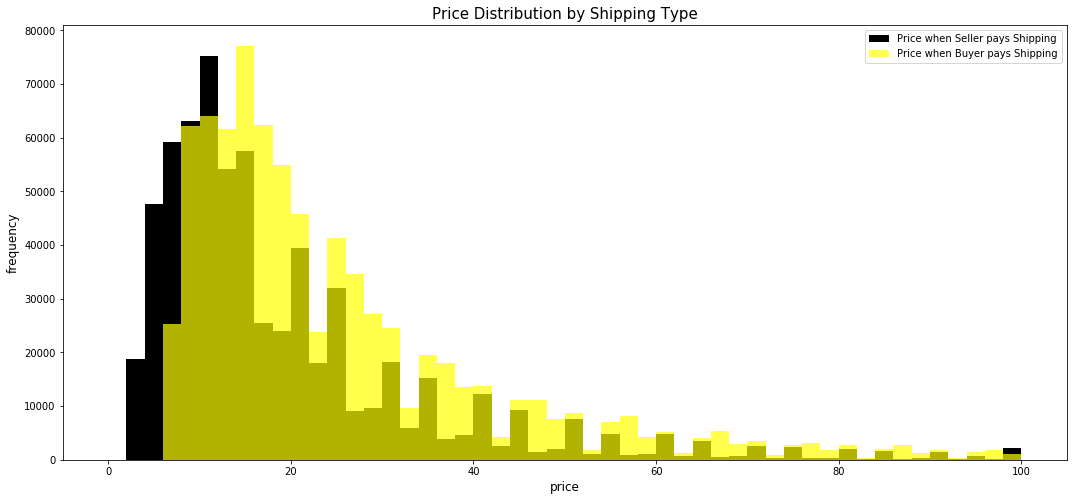

In [24]:
fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_fee_by_seller, color='black', alpha=1.0, bins=50, range = [0, 100],label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='yellow', alpha=0.7, bins=50, range = [0, 100],label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.legend()
plt.show()

In [25]:
print("Mean price when seller pays shipping = {} ".format(round(shipping_fee_by_seller.mean(),2)))
print("Mean price when buyer pays shipping = {} ".format(round(shipping_fee_by_buyer.mean(),2)))

Mean price when seller pays shipping = 22.58 
Mean price when buyer pays shipping = 30.13 


##### Exploring - Categories

In [26]:
top_10_category = train['category_name'].value_counts()[:10].reset_index()
top_10_category

,index,category_name
0,"Women/Athletic Apparel/Pants, Tights, Leggings",60152
1,Women/Tops & Blouses/T-Shirts,46349
2,Beauty/Makeup/Face,34320
3,Beauty/Makeup/Lips,29901
4,Electronics/Video Games & Consoles/Games,26547
5,Beauty/Makeup/Eyes,25200
6,"Electronics/Cell Phones & Accessories/Cases, C...",24668
7,Women/Underwear/Bras,21254
8,"Women/Tops & Blouses/Tank, Cami",20270
9,Women/Tops & Blouses/Blouse,20269


In [27]:
train['category_name'].nunique()

1288

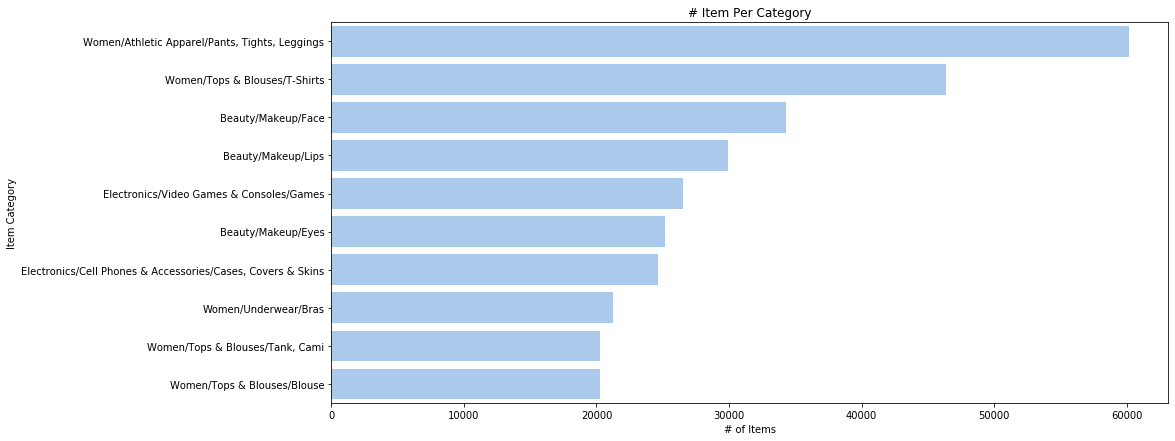

In [28]:
top_10_category = train['category_name'].value_counts()[:10].reset_index()

f, ax = plt.subplots(figsize=(15,7))

# Plot the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="category_name", y='index', data=top_10_category,
            label="# Items" , color="b")

# Add a legend and informative axis label
ax.set( ylabel="Item Category", title='# Item Per Category',
       xlabel="# of Items")

plt.show()

In [29]:
#feature engineering

In [30]:
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [31]:
train['categ_main'], train['categ_sub1'], train['categ_sub2'] = zip(*train['category_name'].apply(transform_category_name))

cat_train = train[['categ_main','categ_sub1','categ_sub2', 'price']]

In [32]:
cat_train.head(20)

,categ_main,categ_sub1,categ_sub2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
4,Women,Jewelry,Necklaces,44.0
5,Women,Other,Other,59.0
6,Women,Swimwear,Two-Piece,64.0
7,Sports & Outdoors,Apparel,Girls,6.0
8,Sports & Outdoors,Apparel,Girls,19.0
9,Vintage & Collectibles,Collectibles,Doll,8.0


In [33]:
train['categ_main'].nunique()

10

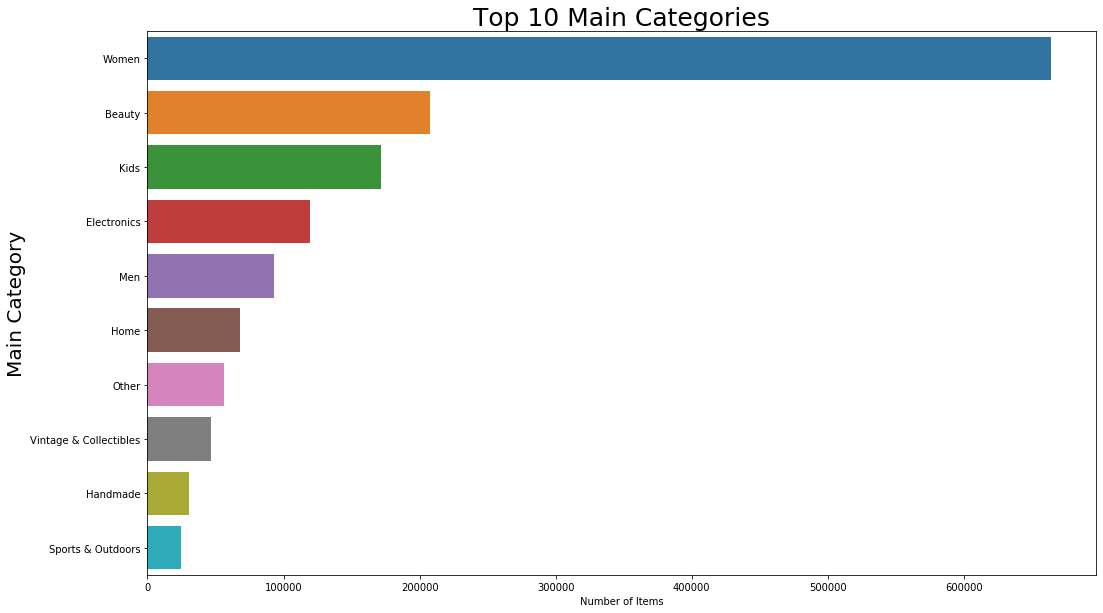

In [34]:
plt.figure(figsize=(17,10))
sns.countplot(y = train['categ_main'], order = train['categ_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

In [35]:
(train['categ_main'].value_counts()/ len(train) * 100).round(2)

Women                     44.81
Beauty                    14.02
Kids                      11.58
Electronics                8.07
Men                        6.30
Home                       4.58
Other                      3.78
Vintage & Collectibles     3.14
Handmade                   2.08
Sports & Outdoors          1.64
Name: categ_main, dtype: float64

##### Exploring - Brand

In [36]:
train['brand_name'].nunique()

4808

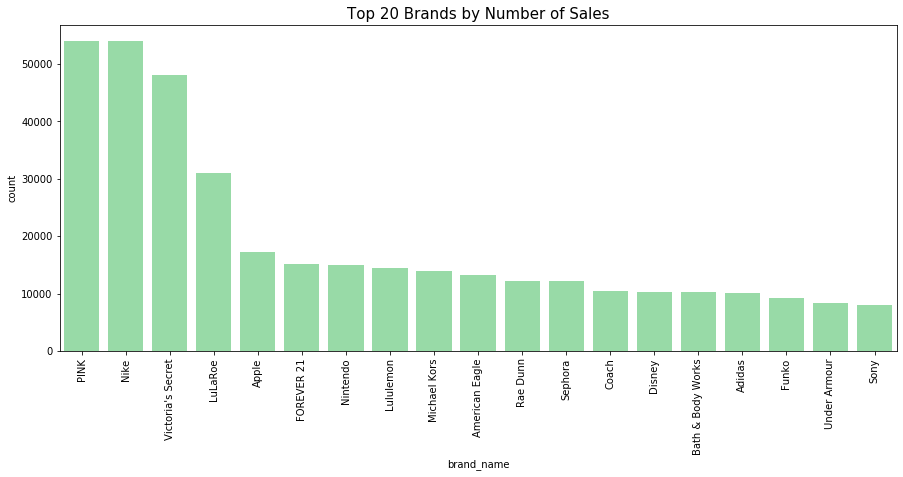

In [37]:
f, ax = plt.subplots(figsize=(15, 6))
top_20_freq = train['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", color='g' , data=top_20_freq)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brands by Number of Sales', fontsize=15)
plt.show()

In [38]:
train['brand_name'].sort_values(ascending=False)[0:20]

945329             wallis
718053     vineyard vines
38545      vineyard vines
1417268    vineyard vines
686905     vineyard vines
637003     vineyard vines
1054576    vineyard vines
1126865    vineyard vines
901744     vineyard vines
1158462    vineyard vines
572889     vineyard vines
862864     vineyard vines
1008606    vineyard vines
1188472    vineyard vines
481151     vineyard vines
637022     vineyard vines
1462767    vineyard vines
1126850    vineyard vines
792106     vineyard vines
1060824    vineyard vines
Name: brand_name, dtype: object

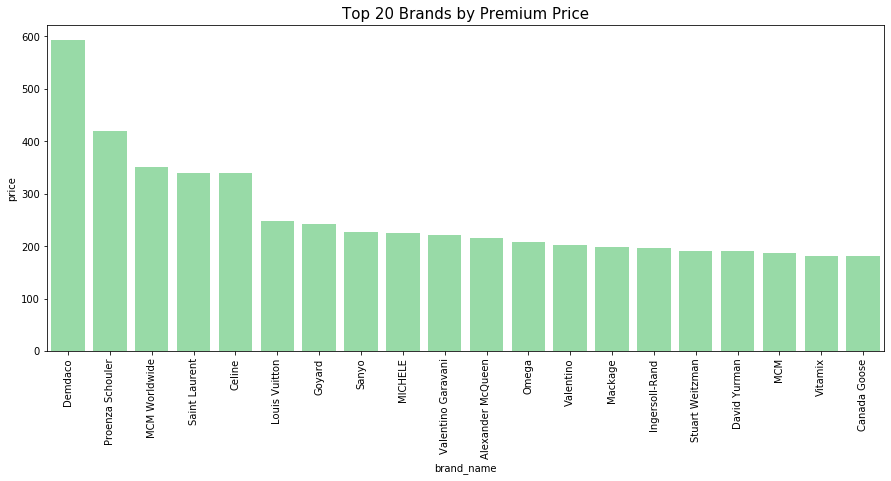

In [39]:
f, ax = plt.subplots(figsize=(15, 6))
top_20_exp_brand = pd.DataFrame(train.groupby(['brand_name']).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", color='g', data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brands by Premium Price', fontsize=15)
plt.show()

In [40]:
##### Exploring - Item Condition

In [41]:
cond = (train['item_condition_id'].value_counts() / len(train))*100
cond

1    43.211369
3    29.149178
2    25.322662
4     2.156026
5     0.160766
Name: item_condition_id, dtype: float64

##### Exploring - Description (Text Data)

In [42]:
descr = train[['name','item_description', 'price']]

In [43]:
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))

C:\Users\srish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
descr.head(20)

,name,item_description,price,count
0,MLB Cincinnati Reds T Shirt Size XL,No description yet,10.0,18
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...,52.0,188
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...,10.0,124
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...,35.0,173
4,24K GOLD plated rose,Complete with certificate of authenticity,44.0,41
5,Bundled items requested for Ruie,"Banana republic bottoms, Candies skirt with ma...",59.0,102
6,Acacia pacific tides santorini top,Size small but straps slightly shortened to fi...,64.0,83
7,Girls cheer and tumbling bundle of 7,You get three pairs of Sophie cheer shorts siz...,6.0,268
8,Girls Nike Pro shorts,Girls Size small Plus green. Three shorts total.,19.0,48
9,Porcelain clown doll checker pants VTG,I realized his pants are on backwards after th...,8.0,297


In [45]:
# Relation between length of description and pricing

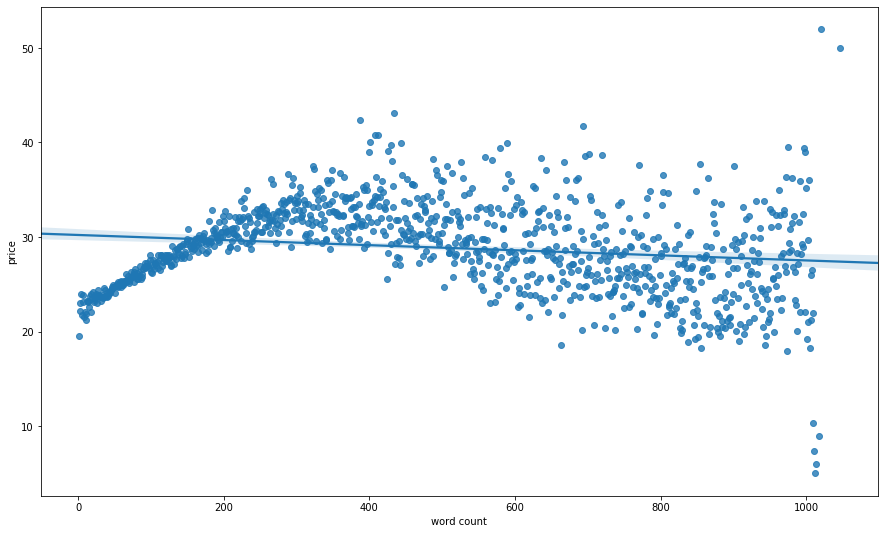

In [46]:
f, ax = plt.subplots(figsize=(15, 9))
df = descr.groupby('count')['price'].mean().reset_index()
#sns.scatterplot(x=df["count"], y=(df["price"]))
sns.regplot(x=df["count"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

### Text Processing

In [85]:
import nltk
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [86]:
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

In [87]:
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in set(stopwords.words('english'))])
    return x

In [88]:
def to_lower(x):
    return x.lower()

In [89]:
reduced_X_train = train.sample(frac=0.05).reset_index(drop=True)
reduced_y_train = np.log1p(reduced_X_train['price'])

In [90]:
reduced_X_train.shape

(74083, 11)

In [91]:
reduced_X_train['item_description'] = reduced_X_train['item_description'].apply(ps.stem)

reduced_X_train['item_description'] = reduced_X_train['item_description'].apply(remove_punctuation)
reduced_X_train['item_description'] = reduced_X_train['item_description'].apply(remove_stop_words)
reduced_X_train['item_description'] = reduced_X_train['item_description'].apply(to_lower)

reduced_X_train['name'] = reduced_X_train['name'].apply(remove_punctuation)
reduced_X_train['name'] = reduced_X_train['name'].apply(remove_stop_words)
reduced_X_train['name'] = reduced_X_train['name'].apply(to_lower)

In [92]:
reduced_X_train['shipping'] = reduced_X_train['shipping'].astype(str)
reduced_X_train['item_condition_id'] = reduced_X_train['item_condition_id'].astype(str)
reduced_X_train['item_description'] = reduced_X_train['item_description'].fillna('None')

##### LDA

In [93]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000,
                              stop_words='english', 
                              lowercase=True)

# Fit it to our dataset
cvz = cvectorizer.fit_transform(reduced_X_train['item_description'])

# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_components=10,
                                      random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: condition | great | good | bag | used | wear | leather | inside | inches | strap
Topic 1: used | worn | condition | size | new | times | great | like | box | good
Topic 2: iphone | plus | case | 21 | forever | 6s | ipad | apple | brandy | cases
Topic 3: new | color | brush | brand | lip | makeup | phone | case | palette | matte
Topic 4: shipping | rm | bundle | free | items | price | save | ask | check | ship
Topic 5: description | skin | new | oil | oz | set | dunn | rae | cream | hair
Topic 6: new | size | worn | brand | black | tags | dress | cute | leggings | color
Topic 7: size | condition | small | worn | medium | fit | shirt | black | great | large
Topic 8: new | free | brand | price | smoke | firm | home | secret | pink | ship
Topic 9: new | brand | rm | gold | box | silver | authentic | free | ring | necklace
Wall time: 4min 36s


##### ELi5

In [94]:
#text processing utility

In [95]:
import eli5

In [96]:
def rmsle_cv(model):
    kf = KFold(shuffle=True, random_state=42).get_n_splits(reduced_X_train['item_description'])
    rmse= np.sqrt(-cross_val_score(model, reduced_X_train['item_description'], reduced_y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

##### Baseline Model with CountVectorizer and Ridge Regression

In [102]:
from sklearn.linear_model import Ridge

vec = CountVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

cv_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_rmsle))

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6892699832127689


In [103]:
eli5.show_weights(pipe, vec=vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.130,1855mm
+0.992,deadstock
+0.943,snapchat
+0.891,nmd
+0.881,limbs
+0.839,macassar
+0.835,releas
+0.821,everywher
+0.808,vnds
+0.783,milwaukee


In [109]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1384], vec=vec)

##### Baseline Model with CountVectorizer and Stop Words

In [110]:
vec = CountVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

cv_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_sw_rmsle))

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.688459943048782


In [111]:
eli5.show_weights(pipe, vec=vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.135,1855mm
+0.997,deadstock
+0.941,snapchat
+0.892,nmd
+0.869,limbs
+0.847,macassar
+0.825,vnds
+0.815,releas
+0.798,everywher
+0.795,milwaukee


In [112]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1384], vec=vec)

##### Baseline Model with TF-IDF

In [113]:
vec = TfidfVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_rmsle))

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6292697698066415


In [114]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1384], vec=vec)

##### Baseline Model with TF-IDF and Stop Words

In [115]:
vec = TfidfVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6299546520668718


In [116]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1384], vec=vec)

##### Baseline Model with TF-IDF, Stop Words, and N-Grams

In [117]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_ng_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6212460011805979


In [118]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1384], vec=vec)

In [119]:
##### Range 1-3 N grapms

In [120]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_ng_rmsle_3ng = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))

C:\Users\srish\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6212460011805979


In [121]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1384], vec=vec)

In [127]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][7878], vec=vec)

In [122]:
# rmsle used when you want to penalize under estimates more than over estimates.

In [123]:
print ("RMSLE Score: " + str(cv_rmsle) + " | CountVectorizer")
print ("RMSLE Score: " + str(cv_sw_rmsle) + " | CountVectorizer & Stop Words")
print ("RMSLE Score: " + str(tfidf_rmsle) + " | TF-IDF")
print ("RMSLE Score: " + str(tfidf_sw_rmsle) + " | TF-IDF & Stop Words")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle) + " | TF-IDF & Stop Words & N-Grams(1-2)")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle_3ng) + " | TF-IDF & Stop Words & N-Grams(1-3)")

RMSLE Score: 0.6892699832127689 | CountVectorizer
RMSLE Score: 0.688459943048782 | CountVectorizer & Stop Words
RMSLE Score: 0.6292697698066415 | TF-IDF
RMSLE Score: 0.6299546520668718 | TF-IDF & Stop Words
RMSLE Score: 0.6212460011805979 | TF-IDF & Stop Words & N-Grams(1-2)
RMSLE Score: 0.6286390682980854 | TF-IDF & Stop Words & N-Grams(1-3)
